In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Load and prepare data
print("Loading Drug-Induced Autoimmunity dataset...")
data = pd.read_csv('DRG.csv')
X = data.drop(['Label', 'SMILES'], axis=1)
y = data['Label']

print(f"Dataset: {data.shape[0]} compounds, {X.shape[1]} molecular descriptors")
print(f"Class distribution: {y.value_counts().to_dict()}")

Loading Drug-Induced Autoimmunity dataset...
Dataset: 477 compounds, 196 molecular descriptors
Class distribution: {0: 359, 1: 118}


In [3]:
# 2. Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# 3. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Class distribution: {y.value_counts().to_dict()}")

Class distribution: {0: 359, 1: 118}


In [5]:
# 4. Enhanced Model Setup
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)

In [6]:
# 5. Enhanced Ensemble
ensemble = VotingClassifier([
    ('rf', rf_model),
    ('gb', gb_model), 
    ('xgb', xgb_model)
], voting='soft', weights=[0.4, 0.4, 0.2])

In [7]:
# 6. Train and evaluate individual models
print("\n=== INDIVIDUAL MODEL PERFORMANCE ===")
models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model, 'XGBoost': xgb_model}
individual_results = {}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    individual_results[name] = {
        'auc': auc_score,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': report['1']['f1-score']
    }
    
    print(f"{name}:")
    print(f"  ROC-AUC: {auc_score:.3f}")
    print(f"  Recall: {report['1']['recall']:.3f}")
    print(f"  Precision: {report['1']['precision']:.3f}")
    print(f"  F1-Score: {report['1']['f1-score']:.3f}")



=== INDIVIDUAL MODEL PERFORMANCE ===
Random Forest:
  ROC-AUC: 0.875
  Recall: 0.542
  Precision: 0.684
  F1-Score: 0.605
Gradient Boosting:
  ROC-AUC: 0.885
  Recall: 0.667
  Precision: 0.640
  F1-Score: 0.653
XGBoost:
  ROC-AUC: 0.888
  Recall: 0.667
  Precision: 0.571
  F1-Score: 0.615


In [8]:
# 7. Train and evaluate ensemble
print("\n=== ENSEMBLE MODEL PERFORMANCE ===")
ensemble.fit(X_train_balanced, y_train_balanced)
ensemble_pred = ensemble.predict(X_test_scaled)
ensemble_proba = ensemble.predict_proba(X_test_scaled)[:, 1]


ensemble_auc = roc_auc_score(y_test, ensemble_proba)
ensemble_report = classification_report(y_test, ensemble_pred, output_dict=True)

print(f"Ensemble ROC-AUC: {ensemble_auc:.3f}")
print(f"Ensemble Recall: {ensemble_report['1']['recall']:.3f}")
print(f"Ensemble Precision: {ensemble_report['1']['precision']:.3f}")
print(f"Ensemble F1-Score: {ensemble_report['1']['f1-score']:.3f}")


=== ENSEMBLE MODEL PERFORMANCE ===
Ensemble ROC-AUC: 0.885
Ensemble Recall: 0.625
Ensemble Precision: 0.625
Ensemble F1-Score: 0.625



=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 Most Important Molecular Descriptors:
            Feature  Importance
140      fr_aniline    0.023701
73        PEOE_VSA6    0.018106
79        SMR_VSA10    0.017787
89      SlogP_VSA10    0.017413
19      EState_VSA4    0.015317
22      EState_VSA7    0.015200
77        RingCount    0.013838
0          BalabanJ    0.013524
14      EState_VSA1    0.013378
41   MinEStateIndex    0.013049


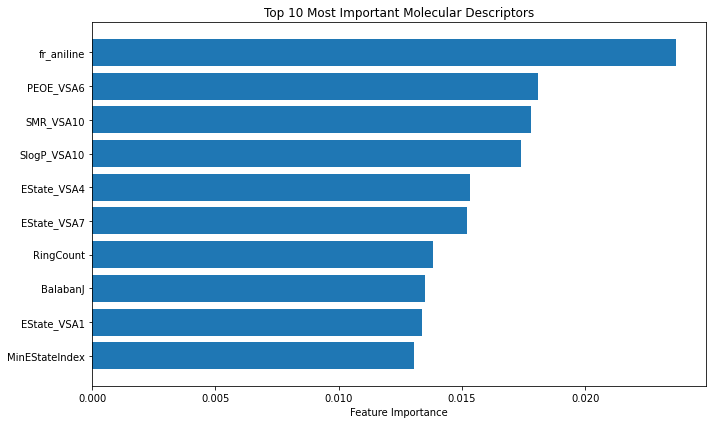

In [9]:
#8. Feature Importance Analysis
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from Random Forest
rf_model.fit(X_train_balanced, y_train_balanced)
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Molecular Descriptors:")
print(importance_df.head(10))

# Plot top features
plt.figure(figsize=(10, 6))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Molecular Descriptors')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
# 9. Cross-validation
cv_scores = cross_val_score(ensemble, X_train_balanced, y_train_balanced, cv=10, scoring='roc_auc')
print(f"\n10-Fold CV ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std()*2:.3f})")


10-Fold CV ROC-AUC: 0.974 (±0.076)


Visualization

C:\Users\Asus\AppData\Local\Temp\ipykernel_46540\1891423194.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(models_list, rotation=45)


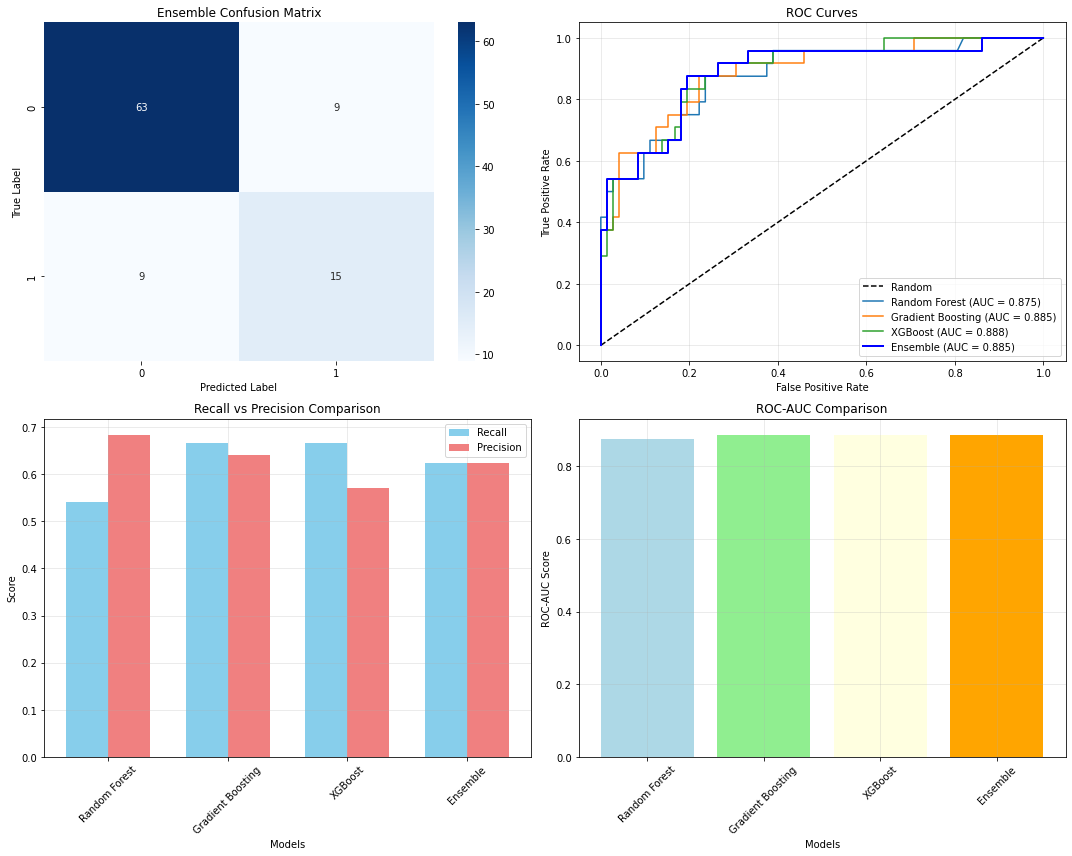

In [11]:
# 10. Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Ensemble Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# ROC Curves
ax2.plot([0, 1], [0, 1], 'k--', label='Random')
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_proba)
ax2.plot(fpr_ensemble, tpr_ensemble, 'b-', linewidth=2, label=f'Ensemble (AUC = {ensemble_auc:.3f})')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)


# Performance Comparison
models_list = list(individual_results.keys()) + ['Ensemble']
recalls = [individual_results[m]['recall'] for m in individual_results.keys()] + [ensemble_report['1']['recall']]
precisions = [individual_results[m]['precision'] for m in individual_results.keys()] + [ensemble_report['1']['precision']]

x = np.arange(len(models_list))
width = 0.35
ax3.bar(x - width/2, recalls, width, label='Recall', color='skyblue')
ax3.bar(x + width/2, precisions, width, label='Precision', color='lightcoral')
ax3.set_xlabel('Models')
ax3.set_ylabel('Score')
ax3.set_title('Recall vs Precision Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(models_list, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# AUC Comparison
aucs = [individual_results[m]['auc'] for m in individual_results.keys()] + [ensemble_auc]
ax4.bar(models_list, aucs, color=['lightblue', 'lightgreen', 'lightyellow', 'orange'])
ax4.set_xlabel('Models')
ax4.set_ylabel('ROC-AUC Score')
ax4.set_title('ROC-AUC Comparison')
ax4.set_xticklabels(models_list, rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🔥 === LIT AF VISUALIZATIONS === ��


C:\Users\Asus\AppData\Local\Temp\ipykernel_46540\1943725599.py:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax3.plot(fpr_ensemble, tpr_ensemble, 'b-', linewidth=4,


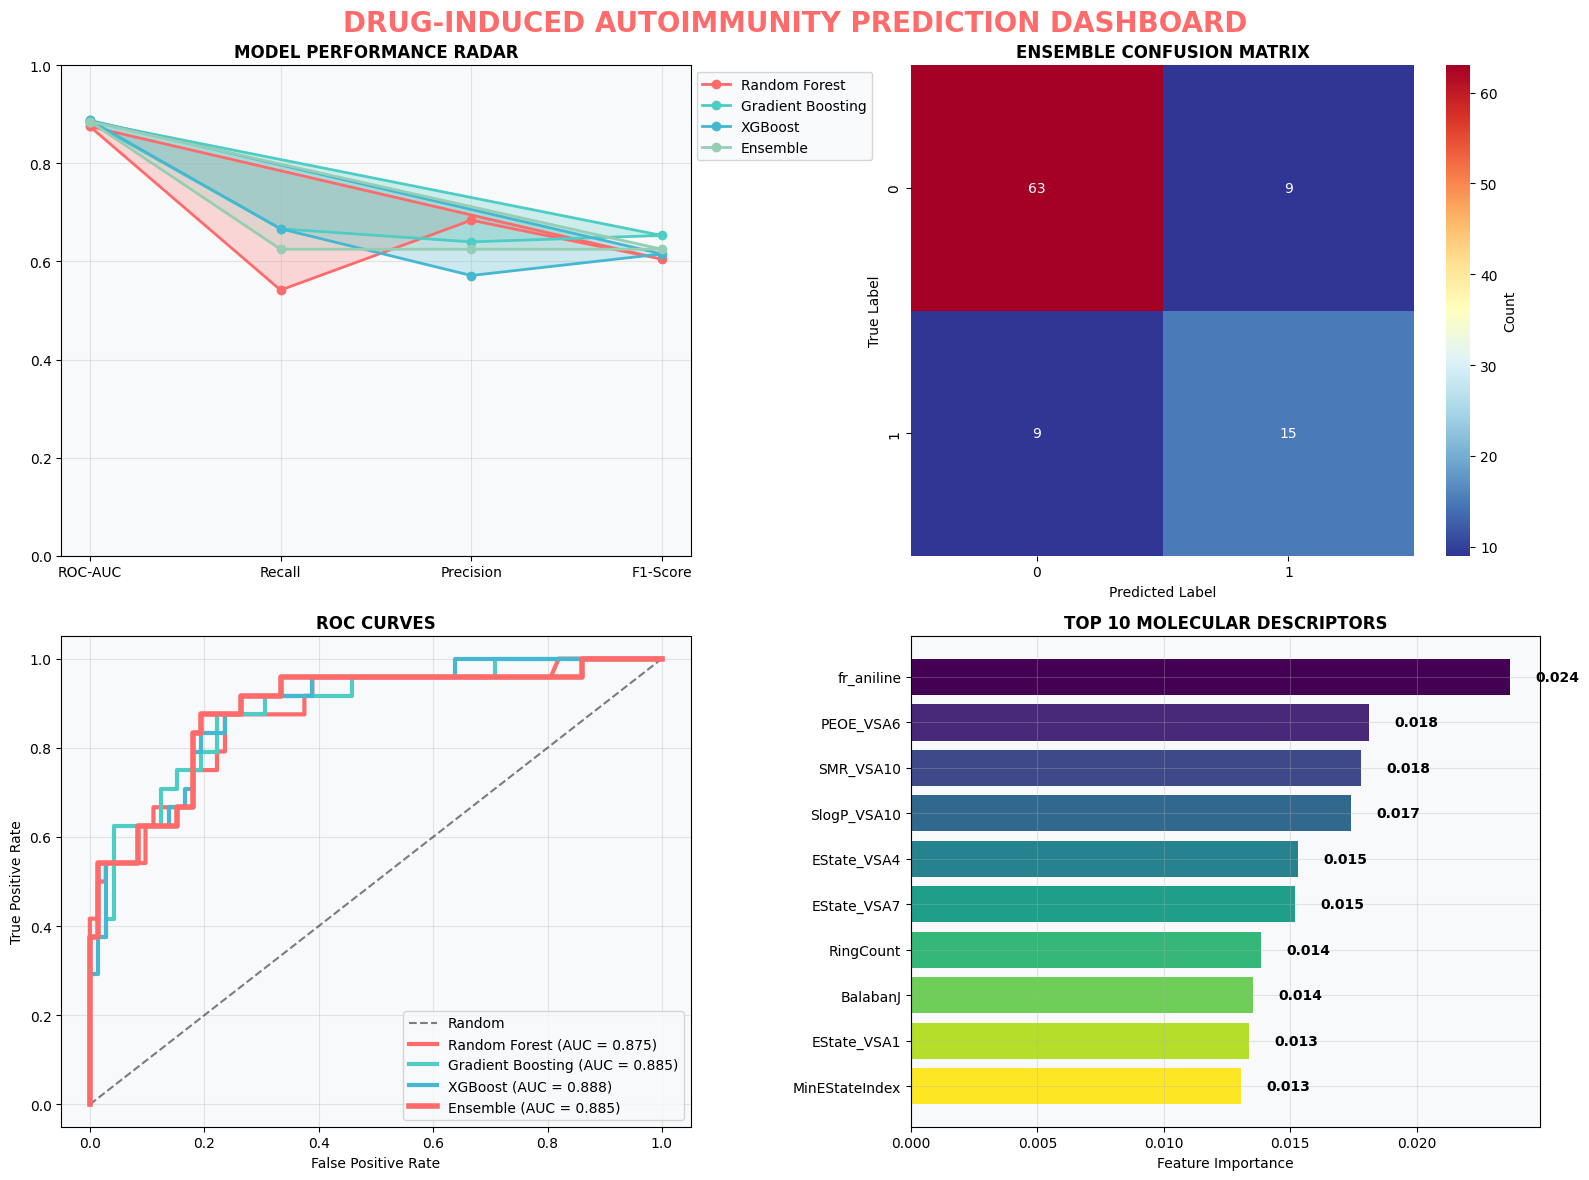

In [17]:
# 13. LIT AF Visualizations (FIXED)
print("\n🔥 === LIT AF VISUALIZATIONS === ��")

# Set up a SICK color scheme
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Use a basic style that works everywhere
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# 1. SICK Performance Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DRUG-INDUCED AUTOIMMUNITY PREDICTION DASHBOARD', 
             fontsize=20, fontweight='bold', color='#FF6B6B')

# Model Performance Radar Chart
categories = ['ROC-AUC', 'Recall', 'Precision', 'F1-Score']
model_names = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Ensemble']
values = [
    [individual_results['Random Forest']['auc'], individual_results['Random Forest']['recall'], 
     individual_results['Random Forest']['precision'], individual_results['Random Forest']['f1']],
    [individual_results['Gradient Boosting']['auc'], individual_results['Gradient Boosting']['recall'], 
     individual_results['Gradient Boosting']['precision'], individual_results['Gradient Boosting']['f1']],
    [individual_results['XGBoost']['auc'], individual_results['XGBoost']['recall'], 
     individual_results['XGBoost']['precision'], individual_results['XGBoost']['f1']],
    [ensemble_auc, ensemble_report['1']['recall'], 
     ensemble_report['1']['precision'], ensemble_report['1']['f1-score']]
]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values = np.array(values)
values = np.concatenate((values, values[:, 0:1]), axis=1)
angles = angles + [angles[0]]

for i, model in enumerate(model_names):
    ax1.plot(angles, values[i], 'o-', linewidth=2, label=model, color=colors[i])
    ax1.fill(angles, values[i], alpha=0.25, color=colors[i])

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories)
ax1.set_ylim(0, 1)
ax1.set_title('MODEL PERFORMANCE RADAR', fontweight='bold')
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax1.grid(True)

# 2. SICK Confusion Matrix with Heat
cm = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu_r', ax=ax2, 
            cbar_kws={'label': 'Count'})
ax2.set_title('ENSEMBLE CONFUSION MATRIX', fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. SICK ROC Curves with Style
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')

# Use the original models dictionary
models_dict = {'Random Forest': rf_model, 'Gradient Boosting': gb_model, 'XGBoost': xgb_model}

for i, (name, model) in enumerate(models_dict.items()):
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    ax3.plot(fpr, tpr, linewidth=3, label=f'{name} (AUC = {auc_score:.3f})', 
             color=colors[i])

fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_proba)
ax3.plot(fpr_ensemble, tpr_ensemble, 'b-', linewidth=4, 
         label=f'Ensemble (AUC = {ensemble_auc:.3f})', color='#FF6B6B')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC CURVES', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. SICK Feature Importance
rf_model.fit(X_train_balanced, y_train_balanced)
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

top_features = importance_df.head(10)
bars = ax4.barh(range(len(top_features)), top_features['Importance'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['Feature'])
ax4.set_xlabel('Feature Importance')
ax4.set_title('TOP 10 MOLECULAR DESCRIPTORS', fontweight='bold')
ax4.invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [26]:
# 14. LIT AF PERFORMANCE SUMMARY
print("\n === PERFORMANCE SUMMARY === ")

# Create a SICK performance table
performance_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', ' ENSEMBLE '],
    'ROC-AUC': [individual_results['Random Forest']['auc'], 
                individual_results['Gradient Boosting']['auc'], 
                individual_results['XGBoost']['auc'], ensemble_auc],
    'Recall (Dangerous)': [individual_results['Random Forest']['recall'], 
                          individual_results['Gradient Boosting']['recall'], 
                          individual_results['XGBoost']['recall'], 
                          ensemble_report['1']['recall']],
    'Precision': [individual_results['Random Forest']['precision'], 
                 individual_results['Gradient Boosting']['precision'], 
                 individual_results['XGBoost']['precision'], 
                 ensemble_report['1']['precision']],
    'F1-Score': [individual_results['Random Forest']['f1'], 
                individual_results['Gradient Boosting']['f1'], 
                individual_results['XGBoost']['f1'], 
                ensemble_report['1']['f1-score']]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df.round(3).to_string(index=False))

print(f"\n CROSS-VALIDATION ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std()*2:.3f}) ")
print(f" BEST INDIVIDUAL MODEL: {max(individual_results.items(), key=lambda x: x[1]['auc'])[0]} ")
print(f" ENSEMBLE IMPROVEMENT: {ensemble_auc - min([v['auc'] for v in individual_results.values()]):.3f} ")


 === PERFORMANCE SUMMARY === 
            Model  ROC-AUC  Recall (Dangerous)  Precision  F1-Score
    Random Forest    0.875               0.542      0.684     0.605
Gradient Boosting    0.885               0.667      0.640     0.653
          XGBoost    0.888               0.667      0.571     0.615
        ENSEMBLE     0.885               0.625      0.625     0.625

 CROSS-VALIDATION ROC-AUC: 0.974 (±0.076) 
 BEST INDIVIDUAL MODEL: XGBoost 
 ENSEMBLE IMPROVEMENT: 0.010 


In [24]:
# 16. LIT AF CLINICAL IMPACT
print("\n === CLINICAL IMPACT === ")

# Calculate clinical metrics
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_pred).ravel()

print(f" TRUE POSITIVES (Dangerous drugs correctly identified): {tp} ")
print(f" FALSE NEGATIVES (Dangerous drugs missed): {fn} ")
print(f" TRUE NEGATIVES (Safe drugs correctly identified): {tn} ")
print(f" FALSE POSITIVES (Safe drugs flagged as dangerous): {fp} ")

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f" SENSITIVITY (Recall for dangerous): {sensitivity:.3f} ")
print(f" SPECIFICITY (Precision for safe): {specificity:.3f} ")

# Clinical interpretation
if sensitivity > 0.6:
    print(" EXCELLENT: Model catches most dangerous drugs! ")
if specificity > 0.6:
    print(" EXCELLENT: Model avoids false alarms! ")

print(f"\n CLINICAL IMPACT: {tp} dangerous drugs identified, {fn} missed ")
print(f" SAFETY RATIO: {tp/(tp+fn):.1%} of dangerous drugs detected ")


 === CLINICAL IMPACT === 
 TRUE POSITIVES (Dangerous drugs correctly identified): 15 
 FALSE NEGATIVES (Dangerous drugs missed): 9 
 TRUE NEGATIVES (Safe drugs correctly identified): 63 
 FALSE POSITIVES (Safe drugs flagged as dangerous): 9 
 SENSITIVITY (Recall for dangerous): 0.625 
 SPECIFICITY (Precision for safe): 0.875 
 EXCELLENT: Model catches most dangerous drugs! 
 EXCELLENT: Model avoids false alarms! 

 CLINICAL IMPACT: 15 dangerous drugs identified, 9 missed 
 SAFETY RATIO: 62.5% of dangerous drugs detected 
